In [20]:
import boto3
from collections import Counter
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tempfile
import os

In [9]:
bucket_name = "skin-lesion-ham10000-euc1"
prefixes = {
    "train": "HAM10000_sorted/train/",
    "val": "HAM10000_sorted/val/"
}

s3 = boto3.client("s3")

In [10]:
def list_classes_in_prefix(bucket, prefix):
    paginator = s3.get_paginator("list_objects_v2")
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)

    classes = []
    for page in pages:
        for obj in page.get("Contents", []):
            parts = obj["Key"].split("/")
            if len(parts) >= 3:
                classes.append(parts[2])
    return classes

In [12]:
counters = {}
for name, pref in prefixes.items():
    classes_list = list_classes_in_prefix(bucket_name, pref)
    counters[name] = Counter(classes_list)

for dataset, counter in counters.items():
    print(f"\n=== {dataset.upper()} ===")
    total = sum(counter.values())
    for cls, count in counter.items():
        print(f"{cls}: {count} ({count/total:.2%})")
    print(f"Total: {total}")


=== TRAIN ===
akiec: 262 (3.27%)
bcc: 411 (5.13%)
bkl: 879 (10.97%)
df: 92 (1.15%)
mel: 890 (11.11%)
nv: 5364 (66.95%)
vasc: 114 (1.42%)
Total: 8012

=== VAL ===
akiec: 65 (3.25%)
bcc: 103 (5.14%)
bkl: 220 (10.98%)
df: 23 (1.15%)
mel: 223 (11.13%)
nv: 1341 (66.95%)
vasc: 28 (1.40%)
Total: 2003


In [14]:
print("\n=== WHOLE DATASET ===")
total_counter = counters["train"] + counters["val"]
total_all = sum(total_counter.values())
for cls, count in total_counter.items():
    print(f"{cls}: {count} ({count/total_all:.2%})")
print(f"Total: {total_all}")


=== WHOLE DATASET ===
akiec: 327 (3.27%)
bcc: 514 (5.13%)
bkl: 1099 (10.97%)
df: 115 (1.15%)
mel: 1113 (11.11%)
nv: 6705 (66.95%)
vasc: 142 (1.42%)
Total: 10015


In [13]:
print("\n=== Comparison of class proportions train vs val ===")
classes = sorted(set().union(*[c.keys() for c in counters.values()]))

for cls in classes:
    train_ratio = counters["train"][cls] / sum(counters["train"].values())
    val_ratio = counters["val"][cls] / sum(counters["val"].values())
    print(f"{cls}: train={train_ratio:.2%}, val={val_ratio:.2%}")


=== Comparison of class proportions train vs val ===
akiec: train=3.27%, val=3.25%
bcc: train=5.13%, val=5.14%
bkl: train=10.97%, val=10.98%
df: train=1.15%, val=1.15%
mel: train=11.11%, val=11.13%
nv: train=66.95%, val=66.95%
vasc: train=1.42%, val=1.40%


In [17]:
def get_one_image_per_class(bucket, prefix):
    paginator = s3.get_paginator("list_objects_v2")
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)

    files_per_class = {}
    for page in pages:
        for obj in page.get("Contents", []):
            parts = obj["Key"].split("/")
            if len(parts) >= 3:
                cls = parts[2]
                files_per_class.setdefault(cls, []).append(obj["Key"])

    return {cls: random.choice(keys) for cls, keys in files_per_class.items()}

sample_files = get_one_image_per_class(bucket_name, prefixes.get("train"))
unique_classes = list(sample_files.keys())

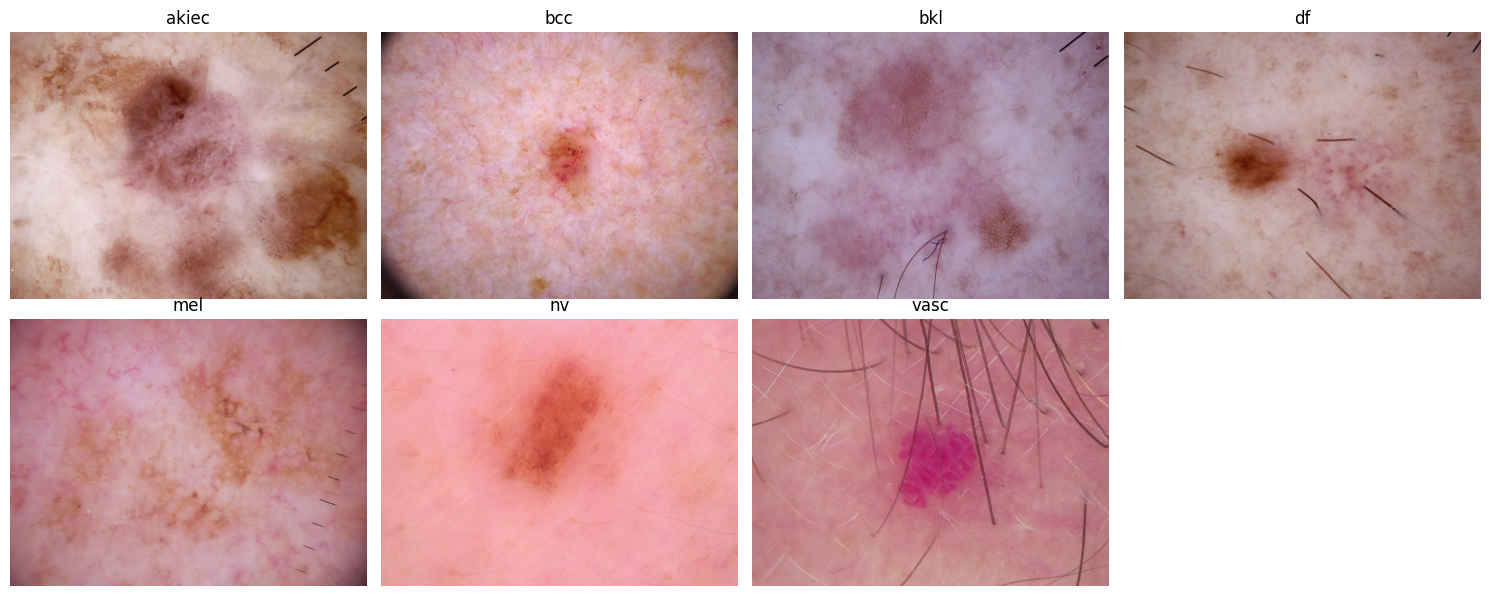

In [22]:
fig, axes = plt.subplots(2, 4, figsize=(15, 6))

for i, cls in enumerate(unique_classes):
    key = sample_files[cls]

    tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".jpg")
    tmp_path = tmp.name
    tmp.close()

    s3.download_file(bucket_name, key, tmp_path)
    img = mpimg.imread(tmp_path)

    ax = axes.flat[i]
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis('off')

    os.remove(tmp_path)

for j in range(len(unique_classes), axes.size):
    axes.flat[j].axis('off')

plt.tight_layout()
plt.show()